### Now, define a full pipeline for calibration, wavefront detection, and then waveform inference with CNN-labeled data!

Pipeline will have the follow inputs:
1. Wavefront detection CNN training video filename, start_s, duration_s
    1. The surfspot (and registered calibration filenames in pipelines.py) is parsed from this training video filename as characters before the first _.
    1. This video is also used for labeling the training data for the CNN via waveform inference 
1. Waveform inference video filename (could be the same as 2., or any other video file from this surfspot)

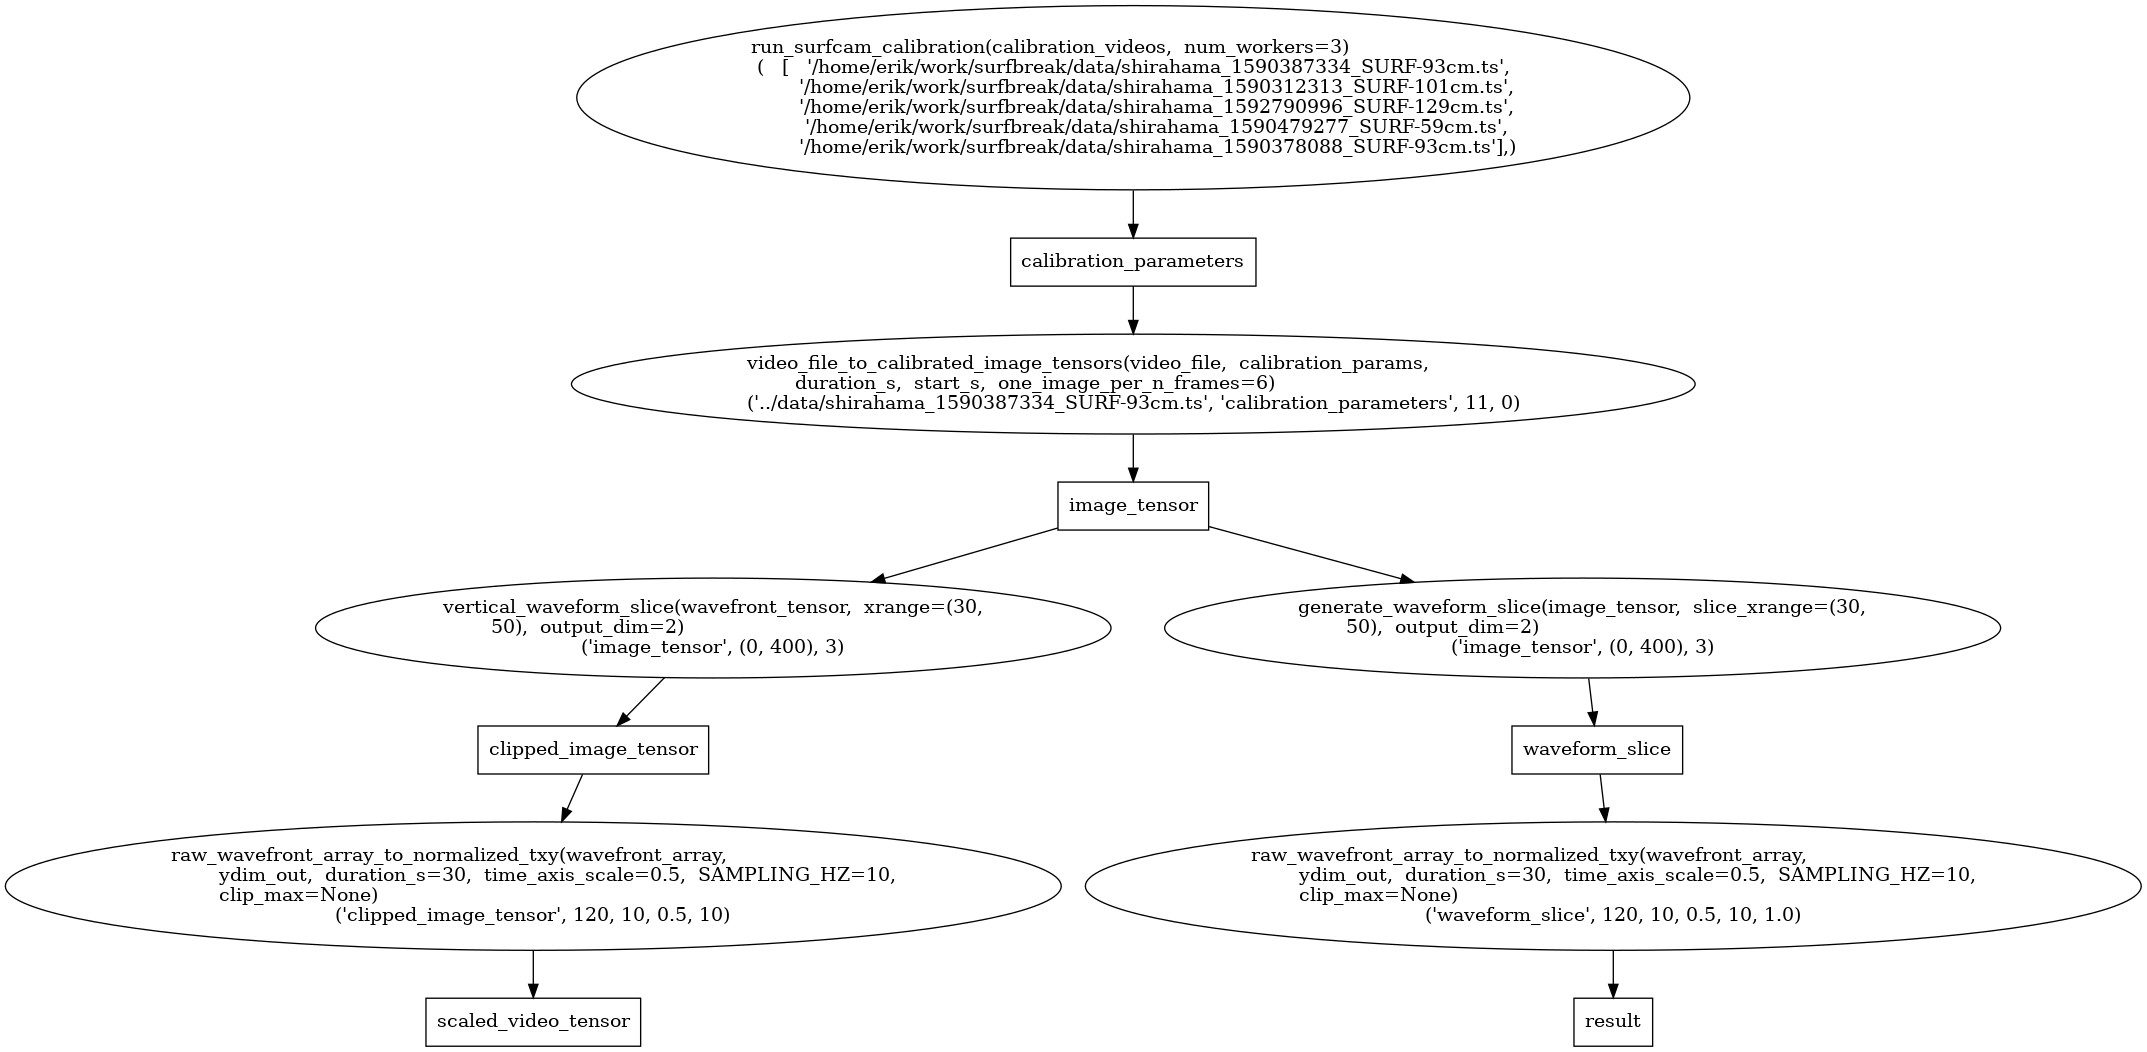

In [ ]:
# This is the calibration and rough wavefront supervision graph used for training the initial wavefront model 
# This graph is generated inside the WaveformVideoDataset class, and used to cache and output training batches
from surfbreak.pipelines import video_to_waveform_tensor
video_filepath='../data/shirahama_1590387334_SURF-93cm.ts'
dask_graph = video_to_waveform_tensor(video_filepath, ydim_out=120, slice_xrange=(0,400),
                                      start_s=0, duration_s=10,  surfspot='shirahama')
from surfbreak.graphutils import visualize
visualize(dask_graph, rankdir='ud')

#### Step 1, calibrate on videos and train a waveform model with basic wavefront supervision

Now we use the graph above to train a wavefunction model on the roughly supervised wavefront signal

In [ ]:
%load_ext autoreload
%autoreload 2
import torch
import pytorch_lightning as pl
from surfbreak.waveform_models import LitSirenNet
from surfbreak.datasets import WaveformVideoDataset, WaveformChunkDataset, InferredWaveformDataset
from datetime import datetime


wf_labeling_training_video = '../data/shirahama_1590387334_SURF-93cm.ts'

def train_basic_waveform_model(training_video, max_epochs=20):
    wf_net_kwargs = dict(
        hidden_features=256,
        hidden_layers=3,
        first_omega_0=2.5,
        hidden_omega_0=11,
        squared_slowness=0.20,
        steps_per_vid_chunk=100,
        learning_rate=1e-4,
        grad_loss_scale=0,
        wavefunc_loss_scale=5.5e-9,
        wavespeed_loss_scale=4e-4, 
        xrange=(0,400),
        timerange=(0,3*30),
        chunk_duration=30,
        chunk_stride=30
    )

    wf_train_video_dataset = WaveformVideoDataset(wf_labeling_training_video, ydim=120, xrange=wf_net_kwargs['xrange'], timerange=wf_net_kwargs['timerange'], 
                                                  time_chunk_duration_s=wf_net_kwargs['chunk_duration'], time_chunk_stride_s=wf_net_kwargs['chunk_stride'], time_axis_scale=0.5)

    wavefunc_model = LitSirenNet(wf_labeling_training_video, **wf_net_kwargs, vid_dataset=wf_train_video_dataset)

    tb_logger = pl.loggers.TensorBoardLogger('logs/', name="pipeline_wf")
    trainer = pl.Trainer(logger=tb_logger, limit_val_batches=3,
                         max_epochs=max_epochs, # 20 
                         gpus=1 if torch.cuda.is_available() else None,)

    pl.seed_everything(42)
    trainer.fit(wavefunc_model)
    
    now = datetime.now() # current date and time
    date_time = now.strftime("%m-%d-%Y_%H-%M-%S")
    checkpoint_filepath = '__graphchain_cache__/pipeline_wf_'+date_time+'.ckpt'
    trainer.save_checkpoint(checkpoint_filepath)
    
    return checkpoint_filepath

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Now use the trained waveform model to label normalized video data, and train a CNN to directly predict the waveform signal

In [ ]:
import torch
import pytorch_lightning as pl
from surfbreak.waveform_models import LitSirenNet, LitWaveCNN

def train_wavefront_detection_cnn(video_filepath, wf_model, max_epochs=20):
    pl.seed_everything(42)
                                 # Params from optimization run: fo 2.4967  ho 10.969  ss 0.20492  wfls 5.4719e-9  wsls 0.00043457
    wavecnn_model = LitWaveCNN(video_filepath=video_filepath, 
                                 wf_model=wavefunc_model, 
                                 learning_rate=1e-4, xrange=(0,400), timerange=(0,90), chunk_duration=30, chunk_stride=30,
                                 n_input_channels=2)

    tb_logger = pl.loggers.TensorBoardLogger('logs/', name="pipeline_cnn")
    trainer = pl.Trainer(logger=tb_logger, limit_val_batches=3,
                         max_epochs=max_epochs, 
                         gpus=1 if torch.cuda.is_available() else None,)


    trainer.fit(wavecnn_model)
    
    now = datetime.now() # current date and time
    date_time = now.strftime("%m-%d-%Y_%H-%M-%S")
    checkpoint_filepath = '__graphchain_cache__/pipeline_cnn_'+date_time+'.ckpt'
    trainer.save_checkpoint(checkpoint_filepath)
    
    return checkpoint_filepath

In [ ]:
wf_labeling_training_video

In [ ]:
def echo(x):
    return x
def training_pipeline(training_video):
    dask_graph = {
        'rough_waveform_model_ckpt': (train_basic_waveform_model, training_video, 10),
        'waveform_cnn_ckpt': (train_wavefront_detection_cnn, training_video, 'rough_waveform_model_ckpt', 20)
    }
    return dask_graph

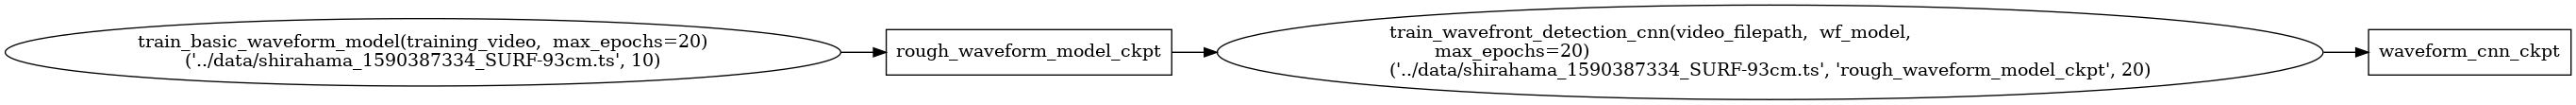

In [ ]:
wf_graph = training_pipeline(wf_labeling_training_video)
visualize(wf_graph)

In [ ]:
import graphchain
cnn_checkpoint = graphchain.get(wf_graph, 'waveform_cnn_ckpt')
cnn_checkpoint

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type  | Params | In sizes     | Out sizes                   
---------------------------------------------------------------------------------------
0 | model          | Siren | 198 K  | [1, 1337, 3] | [[1, 1337, 1], [1, 1337, 3]]
1 | slowness_model | Siren | 8 K    | ?            | ?                           


GPU available: True, used: True
TPU available: False, using: 0 TPU cores
CUDA_VISIBLE_DEVICES: [0]


RuntimeError: Error(s) in loading state_dict for LitSirenNet:
	Missing key(s) in state_dict: "model.net.0.linear.weight", "model.net.0.linear.bias", "model.net.1.linear.weight", "model.net.1.linear.bias", "model.net.2.linear.weight", "model.net.2.linear.bias", "model.net.3.linear.weight", "model.net.3.linear.bias", "model.net.4.weight", "model.net.4.bias", "slowness_model.net.0.linear.weight", "slowness_model.net.0.linear.bias", "slowness_model.net.1.linear.weight", "slowness_model.net.1.linear.bias", "slowness_model.net.2.linear.weight", "slowness_model.net.2.linear.bias", "slowness_model.net.3.weight", "slowness_model.net.3.bias". 
	Unexpected key(s) in state_dict: "wf_model.model.net.0.linear.weight", "wf_model.model.net.0.linear.bias", "wf_model.model.net.1.linear.weight", "wf_model.model.net.1.linear.bias", "wf_model.model.net.2.linear.weight", "wf_model.model.net.2.linear.bias", "wf_model.model.net.3.linear.weight", "wf_model.model.net.3.linear.bias", "wf_model.model.net.4.weight", "wf_model.model.net.4.bias", "wf_model.slowness_model.net.0.linear.weight", "wf_model.slowness_model.net.0.linear.bias", "wf_model.slowness_model.net.1.linear.weight", "wf_model.slowness_model.net.1.linear.bias", "wf_model.slowness_model.net.2.linear.weight", "wf_model.slowness_model.net.2.linear.bias", "wf_model.slowness_model.net.3.weight", "wf_model.slowness_model.net.3.bias", "model.dconv_down1.0.weight", "model.dconv_down1.0.bias", "model.dconv_down2.0.weight", "model.dconv_down2.0.bias", "model.dconv_down3.0.weight", "model.dconv_down3.0.bias", "model.dconv_up2.0.weight", "model.dconv_up2.0.bias", "model.dconv_up1.0.weight", "model.dconv_up1.0.bias", "model.conv_last.weight", "model.conv_last.bias". 